# Experimento com dados de todos os poços

Nesse notebook será realizado as tarefas de obtenção de dados, tratamento, modelagem, e validação de dados.
O objetivo aqui é obter um classificador de anomalias para dados de todos os poços (aqui será incluido todos os tipos de dados: inclusive dados de fontes simulação e desenhados).

# Aquisição de dados

Configurando ambiente: 

In [2]:
# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import utils, config
import pathlib
import numpy as np

# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)

2023-09-28 00:09:39.739919: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 00:09:39.742601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 00:09:39.796845: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 00:09:39.797781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 00:09:40.842066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Baixar dataset 3W (se não disponível) & gerar tabela de metadados.

In [3]:
## Acquire data (of entire 3W dataset)
rda.acquire_dataset_if_needed()
latest_converted_data_path, latest_converted_data_version = (
    rda.get_latest_local_converted_data_version(config.DIR_PROJECT_DATA)
)

# Helper to overview metadata (of entire 3W dataset)
inspector_all_data = rdi.RawDataInspector(
    dataset_dir=latest_converted_data_path,
    cache_file_path=config.PATH_DATA_INSPECTOR_CACHE,
    use_cached=True
)
metadata_all_data = inspector_all_data.get_metadata_table()
metadata_all_data

INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101
INFO:absl:Latest local version is 10101
INFO:absl:Going to fetch config file from $https://raw.githubusercontent.com/petrobras/3W/main/dataset/dataset.ini
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2786  100  2786    0     0   4609      0 --:--:-- --:--:-- --:--:--  4612
INFO:absl:Latest online version is 10101
INFO:absl:Found existing converted data with dataset version of 10101
INFO:absl:Directory with the biggest version: /home/ubuntu/lemi_3w/data/dataset_converted_v10101
INFO:absl:Version: 10101


,class_type,source,well_id,path,timestamp,file_size,num_timesteps
hash_id,,,,,,,
74203bb,NORMAL,REAL,1.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-24 03:00:00,491415,17885
9fbd6f9,NORMAL,REAL,2.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-09 06:00:00,520154,17933
28804c5,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-05-08 09:00:31,349162,17970
42afe91,NORMAL,REAL,8.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-07-01 14:01:35,251880,17799
fa71d94,NORMAL,REAL,6.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-08-23 19:00:00,279737,17949
...,...,...,...,...,...,...,...
ea66cf6,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2315903,61999
34f032a,SEVERE_SLUGGING,SIMULATED,NaN,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,NaT,2259539,61999
876a969,SEVERE_SLUGGING,REAL,14.0,/home/ubuntu/lemi_3w/data/dataset_converted_v1...,2017-09-25 06:00:42,1005717,17959


Dividir dados (de forma estratificada) em treinamento e teste.

In [4]:
# splits data, from the selected well, into train and test datasets
splitter = rds.RawDataSplitter(metadata_all_data, latest_converted_data_version)
split_train_dir, split_test_dir = splitter.stratefy_split_of_data(
    data_dir=config.DIR_PROJECT_DATA, 
    test_size=0.20,
)

# generates metadata tables for split data
train_metadata = rdi.RawDataInspector(
    dataset_dir=split_train_dir,
    cache_file_path=config.DIR_PROJECT_CACHE / "train_metadata_all_data.parquet",
    use_cached=True,
)
test_metadata = rdi.RawDataInspector(
    dataset_dir=split_test_dir,
    cache_file_path=config.DIR_PROJECT_CACHE / "test_metadata_all_data.parquet",
    use_cached=True,
)

DEBUG:absl:size of train data: 1582 --- size of test data: 396
DEBUG:absl:train path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train --- test path /home/ubuntu/lemi_3w/data/dataset_converted_v10101_split-20_source-all_class-all_well-all_test


DONE:   0%|          | 0/1582 [00:00<?, ?it/s]

DONE:   0%|          | 0/396 [00:00<?, ?it/s]

Tabela de anomalias por tipo de fonte - treinamento.

In [5]:
rdi.RawDataInspector.generate_table_by_anomaly_source(train_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,475,0,0,475
ABRUPT_INCREASE_BSW,4,91,8,103
SPURIOUS_CLOSURE_DHSV,18,13,0,31
SEVERE_SLUGGING,25,59,0,84
FLOW_INSTABILITY,275,0,0,275
RAPID_PRODUCTIVITY_LOSS,9,351,0,360
QUICK_RESTRICTION_PCK,5,172,0,177
SCALING_IN_PCK,4,0,8,12
HYDRATE_IN_PRODUCTION_LINE,0,65,0,65


Tabela de anomalias por tipo de fonte - teste.

In [6]:
rdi.RawDataInspector.generate_table_by_anomaly_source(test_metadata.get_metadata_table())

,real_count,simul_count,drawn_count,soma
anomaly,,,,
NORMAL,119,0,0,119
ABRUPT_INCREASE_BSW,1,23,2,26
SPURIOUS_CLOSURE_DHSV,4,3,0,7
SEVERE_SLUGGING,7,15,0,22
FLOW_INSTABILITY,69,0,0,69
RAPID_PRODUCTIVITY_LOSS,2,88,0,90
QUICK_RESTRICTION_PCK,1,43,0,44
SCALING_IN_PCK,1,0,2,3
HYDRATE_IN_PRODUCTION_LINE,0,16,0,16


# Procesamento de dados

Remoção de valores extremos.

In [7]:
from parallelbar import progress_map

def is_event_path_values_valid(event_path):
    event = utils.get_event(event_path)
    return TransformationManager.is_event_values_valid(event)

valid_index_list = progress_map(is_event_path_values_valid, train_metadata.get_metadata_table()['path'].to_list())

non_valid_ids = [index for index, value in enumerate(valid_index_list) if value == False]
non_valid_ids

DONE:   0%|          | 0/1582 [00:00<?, ?it/s]

[779, 804, 939, 1077, 1205, 1221, 1469, 1474, 1482, 1487, 1496]

In [8]:
len(non_valid_ids)

11

In [9]:
valid_train_metadata = train_metadata.get_metadata_table().copy()
print("stating size is:", len(valid_train_metadata))

valid_train_metadata.drop(valid_train_metadata.index[non_valid_ids], inplace=True, axis='index')
print("final size is:", len(valid_train_metadata))

stating size is: 1582
final size is: 1571


Pegar valores da média dos valores e do desvio padrão.

In [10]:
from data_exploration.metric_acquisition import MetricAcquisition

cache_file_name = "all_data_metrics"

metric_aquisition = MetricAcquisition(valid_train_metadata)
mean_and_std_metric_table = metric_aquisition.get_mean_and_std_metric(
    cache_file_name=cache_file_name,
    use_cache=False
)

mean_metric_list = mean_and_std_metric_table['mean_of_means']
std_metric_list = mean_and_std_metric_table['mean_of_stds']
mean_and_std_metric_table

DONE:   0%|          | 0/1571 [00:00<?, ?it/s]

DEBUG:absl:Mean of means was adquired
             P-PDG         P-TPT       T-TPT     P-MON-CKP   T-JUS-CKP  \
0     0.000000e+00  1.420389e+07  116.794133  6.122810e+06   69.415705   
1     0.000000e+00  8.715824e+06  117.581821  1.539264e+06   77.332955   
2     4.203851e+07  1.806945e+07  118.569073  2.492268e+06   79.545939   
3     4.485805e+07  2.114707e+07  116.569785  1.224582e+07   61.885166   
4     0.000000e+00  1.001934e+07  119.033867  1.575567e+06   84.148449   
...            ...           ...         ...           ...         ...   
1566  2.424625e+07  1.511253e+07   44.579236  2.051035e+06   26.684643   
1567  1.539201e+07  8.925425e+06  120.387588  4.042629e+06   94.437207   
1568  2.077121e+07  1.138257e+07  119.183729  4.102729e+06   88.286792   
1569  1.660494e+07  9.154420e+06  122.202564  4.044520e+06  101.257945   
1570  1.898863e+07  1.076657e+07  116.316665  4.090173e+06   78.424427   

        P-JUS-CKGL       QGL  
0     3.052964e+06  0.000000  
1     2.320

DONE:   0%|          | 0/1571 [00:00<?, ?it/s]

DEBUG:absl:Mean of stds was adquired
             P-PDG         P-TPT      T-TPT     P-MON-CKP  T-JUS-CKP  \
0     1.650576e+07  9.560377e+05  10.788350  1.386987e+06   9.296645   
1     1.650575e+07  6.443865e+06  11.579913  3.207690e+06   1.566184   
2     2.698859e+07  2.910419e+06  12.563287  2.244048e+06   0.834540   
3     2.835355e+07  5.988118e+06  10.563945  7.509773e+06  16.826856   
4     1.650575e+07  5.139956e+06  13.028115  3.165817e+06   5.453787   
...            ...           ...        ...           ...        ...   
1566  7.749604e+06  1.084187e+06  62.636791  3.043686e+06  52.427836   
1567  1.300814e+06  6.260501e+06  14.390051  6.940030e+05  15.852241   
1568  4.469475e+06  4.019682e+06  13.210729  6.393561e+05   9.993714   
1569  7.029180e+05  6.032929e+06  16.198869  6.920534e+05  22.584042   
1570  2.711583e+06  4.543515e+06  10.404993  6.523434e+05   4.640841   

        P-JUS-CKGL       QGL  
0     3.630303e+08  0.257624  
1     3.637628e+08  0.257624  
2    

,mean_of_means,mean_of_stds
P-PDG,1.650529e+07,1.198862e+07
P-TPT,1.515912e+07,3.677846e+06
T-TPT,1.060061e+02,1.617829e+01
P-MON-CKP,4.736253e+06,3.066275e+06
T-JUS-CKP,7.871146e+01,1.837630e+01
P-JUS-CKGL,3.660731e+08,2.497236e+08
QGL,2.576171e-01,1.560193e-01


Realizar a transformação dos dados.

In [18]:
train_tranformed_folder_name = split_train_dir.name

train_transformation_manager = TransformationManager(
    valid_train_metadata, 
    output_folder_base_name=train_tranformed_folder_name
)

transformation_param_sample_interval_seconds=60
transformation_param_num_timesteps_for_window=20

train_transformation_manager.apply_transformations_to_table(
    output_parent_dir=config.DIR_PROJECT_DATA,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

DEBUG:absl:TransformationManager initialized with 1571 items.
            Folder name is dataset_converted_v10101_split-20_source-all_class-all_well-all_train.


DONE:   0%|          | 0/1571 [00:00<?, ?it/s]

# Verificação dos dados

Garantir que os dados processados estão dentro das especificações esperadas.

Obter lista dos arquivos a serem usados no treinamento.

In [19]:
# Get transformed files paths
train_tranformed_dataset_dir = (
    config.DIR_PROJECT_DATA / 
    (TransformationManager.TRANSFORMATION_NAME_PREFIX + train_tranformed_folder_name))

train_transformed_inspector = rdi.RawDataInspector(
    train_tranformed_dataset_dir,
    config.DIR_PROJECT_CACHE / "inspector_transformed_all_data_train.parquet",
    False
)
train_transformed_metadata = train_transformed_inspector.get_metadata_table()
train_transformed_data_file_path_list = train_transformed_metadata["path"]
print("There are", len(train_transformed_data_file_path_list), "files available")


def data_generator_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    while True:
        for file_path in file_path_list:
            X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
            yield X, y

def data_generator_non_loop(file_path_list):
    """Generator returning batches of data for each file path"""
    for file_path in file_path_list:
        X, y = TransformationManager.retrieve_pair_array(pathlib.Path(file_path))
        yield X, y

INFO:absl:Processing 475 events of class type 0.


DONE:   0%|          | 0/475 [00:00<?, ?it/s]

INFO:absl:Processing 275 events of class type 4.


DONE:   0%|          | 0/275 [00:00<?, ?it/s]

INFO:absl:Processing 356 events of class type 5.


DONE:   0%|          | 0/356 [00:00<?, ?it/s]

INFO:absl:Processing 102 events of class type 1.


DONE:   0%|          | 0/102 [00:00<?, ?it/s]

INFO:absl:Processing 11 events of class type 7.


DONE:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:absl:Processing 177 events of class type 6.


DONE:   0%|          | 0/177 [00:00<?, ?it/s]

INFO:absl:Processing 65 events of class type 8.


DONE:   0%|          | 0/65 [00:00<?, ?it/s]

INFO:absl:Processing 26 events of class type 2.


DONE:   0%|          | 0/26 [00:00<?, ?it/s]

INFO:absl:Processing 84 events of class type 3.


DONE:   0%|          | 0/84 [00:00<?, ?it/s]

INFO:absl:Found 9.


There are 1571 files available


Exemplo de um par X, y.

In [20]:
example_transformed_file_path = train_transformed_data_file_path_list[0]
X_transformed_ex, y_transformed_ex = TransformationManager.retrieve_pair_array(pathlib.Path(example_transformed_file_path))

X_transformed_ex[0], y_transformed_ex[0]

(array([[ 0.75864691, -0.49551917,  0.23780831, -1.5446273 , -4.28331258,
         -1.45382636, -1.65118699],
        [ 0.75860551, -0.4954927 ,  0.23708512, -1.5446273 , -4.28331258,
         -1.45402941, -1.65118699],
        [ 0.75856625, -0.49558206,  0.23822585, -1.5446273 , -4.28331258,
         -1.45384658, -1.65118699],
        [ 0.75865375, -0.49557074,  0.23817012, -1.5446273 , -4.28331258,
         -1.45475668, -1.65118699],
        [ 0.75858676, -0.49601851,  0.23770066, -1.5446273 , -4.28331258,
         -1.45514094, -1.65118699],
        [ 0.75855635, -0.49631682,  0.23736162, -1.5446273 , -4.28331258,
         -1.45511546, -1.65118699],
        [ 0.75855014, -0.49600999,  0.23863968, -1.5446273 , -4.28331258,
         -1.45545321, -1.65118699],
        [ 0.7586058 , -0.49574217,  0.23899128, -1.5446273 , -4.28331258,
         -1.45551064, -1.65118699],
        [ 0.75856347, -0.49542799,  0.2375416 , -1.5446273 , -4.28331258,
         -1.45528381, -1.65118699],
        [ 

Verificar valores mínimos e máximos dos dados.

In [35]:
X_min_list = []
X_max_list = []
y_avg = []

for path in train_transformed_data_file_path_list:
    X, y = TransformationManager.retrieve_pair_array(pathlib.Path(path))
    X_min_list.append(np.min(np.min(X, axis=0), axis=0))
    X_max_list.append(np.max(np.max(X, axis=0), axis=0))
    y_avg.append(np.sum(y, axis=0) / len(y))

X_min_list = np.array(X_min_list)
X_max_list = np.array(X_max_list)
y_avg = np.array(y_avg)

In [22]:
# Regarding minimum values of X
print("Minimum minimum values:\n", X_min_list.min(axis=0))

print("\n\nMinimum average values:\n", X_min_list.mean(axis=0))

print("\n\nMinimum maximum values:\n", X_min_list.max(axis=0))

Minimum minimum values:
 [-10.75886275  -4.12173948  -6.55237227  -1.5446273   -4.37451683
  -1.46790608  -1.65118699]


Minimum average values:
 [-0.10074786 -0.27392489 -1.00984543 -0.24732616 -0.47394007 -0.79176123
 -1.11980315]


Minimum maximum values:
 [2.36497267 2.05474575 1.32479209 2.46095192 5.13621461 6.79733987
 9.87521034]


In [23]:
# Regarding max values of X
print("Maximum minimum values:\n", X_max_list.min(axis=0))

print("\n\nMaximum average values:\n", X_max_list.mean(axis=0))

print("\n\nMaximum maximum values:\n", X_max_list.max(axis=0))

Maximum minimum values:
 [-1.95128059 -4.12173948 -6.55237227 -1.5446273  -4.28331258 -1.46790608
 -1.65118699]


Maximum average values:
 [ 0.09014727  0.25617844 -0.45679081  0.02910067  0.05816041 -0.77589883
 -0.92244018]


Maximum maximum values:
 [ 2.36497267  4.7185472   1.34340171  2.70682883  5.13621461 14.22992377
 14.19088608]


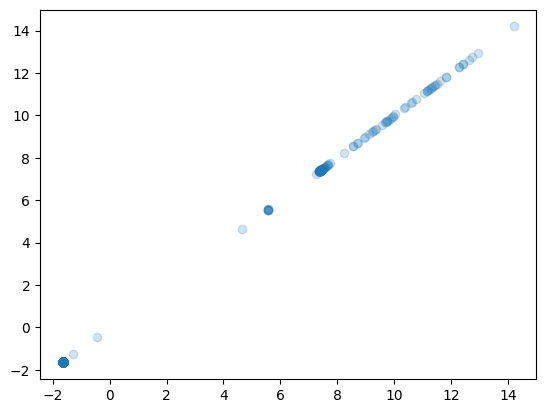

In [24]:
import matplotlib.pyplot as plt

variable_index = 6
plt.scatter(X_max_list[:, variable_index], X_max_list[:, variable_index], alpha=0.2)

In [34]:
np.mean(np.mean(y_avg, axis=0), axis=0)

array([-6.30359201e-04, -2.76826875e-02, -7.60865505e-01, -5.22171510e-02,
       -2.13618105e-01, -7.88481113e-01, -1.01930234e+00])

In [36]:
# Regarding mean values of y
print("Mean y minimum values:\n", y_avg.min(axis=0))

print("\n\nMean y average values:\n", y_avg.mean(axis=0))

print("\n\nMean y maximum values:\n", y_avg.max(axis=0))

Mean y minimum values:
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]


Mean y average values:
 [0.32054594 0.05876751 0.01269103 0.05346913 0.17504774 0.22561859
 0.10799521 0.00554481 0.04031898]


Mean y maximum values:
 [1.         0.99120235 0.9521127  1.         1.         1.
 0.97447795 0.9465409  0.97447795]


In [26]:
y_avg.sum(axis=0)

array([1571.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
      dtype=float32)

Analisando exemplo de tranformação para ver problemas com a label output.

In [28]:
#from data_exploration import visualization_helper as visual
#visual.display_entire_event(bad_data, 1, True, 'linear', lang='pt')

NameError: name 'bad_data' is not defined

# Modelagem

Montagem da estrutura do modelo.

In [37]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from constants import module_constants

num_features = X_transformed_ex.shape[2]
num_outputs = module_constants.num_class_types

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(transformation_param_num_timesteps_for_window, num_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_outputs, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 9)                 909       
                                                                 
Total params: 17609 (68.79 KB)
Trainable params: 17609 (68.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo.

In [38]:
num_epochs = 15
# times the generator (data_gen) should be called to complete one full pass through your training dataset
steps_per_epoch = len(train_transformed_data_file_path_list)


train_data_gen = data_generator_loop(train_transformed_data_file_path_list)


# Train the model
model.fit(
    train_data_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs, 
    verbose=1
)

Epoch 1/15
1571/1571 [==============================] - 34s 21ms/step - loss: 2.0525 - accuracy: 0.6757
Epoch 2/15
1571/1571 [==============================] - 31s 20ms/step - loss: 1.1192 - accuracy: 0.7215
Epoch 3/15
1571/1571 [==============================] - 31s 20ms/step - loss: 0.9287 - accuracy: 0.7682
Epoch 4/15
1571/1571 [==============================] - 30s 19ms/step - loss: 0.6974 - accuracy: 0.8111
Epoch 5/15
1571/1571 [==============================] - 31s 20ms/step - loss: 0.5367 - accuracy: 0.8394
Epoch 6/15
1571/1571 [==============================] - 30s 19ms/step - loss: 0.4609 - accuracy: 0.8536
Epoch 7/15
1571/1571 [==============================] - 31s 19ms/step - loss: 0.4510 - accuracy: 0.8689
Epoch 8/15
1571/1571 [==============================] - 30s 19ms/step - loss: 0.4007 - accuracy: 0.8748
Epoch 9/15
1571/1571 [==============================] - 30s 19ms/step - loss: 0.5242 - accuracy: 0.8749
Epoch 10/15
1571/1571 [==============================] - 31s 20m

Ver se está funcionando com um exemplo.

In [ ]:
import numpy as np
test_file = train_transformed_data_file_path_list[-1]
print(test_file)

Xhat, yhat = TransformationManager.retrieve_pair_array(pathlib.Path(test_file))
print(f"True value: {yhat[0]}")

Xhat0 = Xhat[0].reshape(1, transformation_param_num_timesteps_for_window, num_features)
print(f"Predicted value: {model.predict(Xhat0)}")

# Validação
Aqui pegaremos nosso banco de testes, o transformaremos, para então o utilizar para validar a perfomance do nosso modelo.

Obter lista de arquivos usados para a validação.

In [ ]:
test_tranformed_folder_name = split_test_dir.name

test_transformation_manager = TransformationManager(
    test_metadata.get_metadata_table(), 
    output_folder_base_name=test_tranformed_folder_name
)

test_transformation_manager.apply_transformations_to_table(
    output_parent_dir=config.DIR_PROJECT_DATA,
    sample_interval_seconds=transformation_param_sample_interval_seconds,
    num_timesteps_for_window=transformation_param_num_timesteps_for_window,
    avg_variable_mean=mean_metric_list,
    avg_variable_std_dev=std_metric_list,
)

# Get transformed files paths
test_tranformed_dataset_dir = (
    config.DIR_PROJECT_DATA / 
    (TransformationManager.TRANSFORMATION_NAME_PREFIX + test_tranformed_folder_name)
)

test_transformed_inspector = rdi.RawDataInspector(
    test_tranformed_dataset_dir,
    config.DIR_PROJECT_CACHE / "inspector_transformed_all_data_test.parquet",
    True
)
test_transformed_metadata = test_transformed_inspector.get_metadata_table()
test_transformed_file_path_list = test_transformed_metadata["path"]
test_transformed_file_path_list

In [ ]:
test_data_gen = data_generator_non_loop(test_transformed_file_path_list)
num_steps = len(test_transformed_file_path_list)

model.evaluate(
    test_data_gen,
    verbose=1,
)

In [ ]:
test_data_gen = data_generator_non_loop(test_transformed_file_path_list)

y_test_predictions = model.predict(
    test_data_gen,
)

(
    f"Number of predictions: {len(y_test_predictions)}", 
    f"Shape of y array: {y_test_predictions.shape}", 
    y_test_predictions[0]
)

In [ ]:
test_data_gen = data_generator_non_loop(test_transformed_file_path_list)
y_test_labels = []

for X, y in test_data_gen:
    y_test_labels.append(y)

y_test_labels = np.concatenate(y_test_labels, axis=0)

(
    f"Number of predictions: {len(y_test_labels)}", 
    f"Shape of y array: {y_test_labels.shape}", 
    y_test_labels[0],
)

In [ ]:
from tensorflow.math import confusion_matrix

y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)